In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import glob

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import scipy.interpolate

# dLux imports
import dLux as dl
import dLux.utils as dlu


%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

In [2]:
#files = glob.glob("../batch/timeseries-orbit/*.npz")
files = [f"../batch/timeseries-orbit/{i}.npz" for i in range(20)]
print(files)
#files.sort()
files = [f for f in files if ("/8." not in f) and ("/11." not in f) ]#[5:6]
print(len(files))

['../batch/timeseries-orbit/0.npz', '../batch/timeseries-orbit/1.npz', '../batch/timeseries-orbit/2.npz', '../batch/timeseries-orbit/3.npz', '../batch/timeseries-orbit/4.npz', '../batch/timeseries-orbit/5.npz', '../batch/timeseries-orbit/6.npz', '../batch/timeseries-orbit/7.npz', '../batch/timeseries-orbit/8.npz', '../batch/timeseries-orbit/9.npz', '../batch/timeseries-orbit/10.npz', '../batch/timeseries-orbit/11.npz', '../batch/timeseries-orbit/12.npz', '../batch/timeseries-orbit/13.npz', '../batch/timeseries-orbit/14.npz', '../batch/timeseries-orbit/15.npz', '../batch/timeseries-orbit/16.npz', '../batch/timeseries-orbit/17.npz', '../batch/timeseries-orbit/18.npz', '../batch/timeseries-orbit/19.npz']
18


In [3]:
defocuses = []
errs = []
mjds = []
fluxes = []
mjd_start = []
aberrations=[]
pams=[]
for file in files:
    with np.load(file) as res:
        print(file)
        #print(res)
        #print(len(res["defocuses"]))
        #print(res["cold_shift"])
        defocus = res["defocuses"]
        err = res["errs"]
        mjd_sec = res["mjds"]#*24*60 
        flux = res["spectra"]
        aberration = res["aberrations"]
        pam = res["pams"]
        if (np.max(mjd_sec)-np.min(mjd_sec))<1.:
            mjd_sec *= 24*60

        mjd_start.append(mjd_sec[0]/24/60)

        mjd_sec -= mjd_sec[0]
        

        mask = np.logical_and(np.logical_and(defocus < 200, defocus > 100), np.squeeze(np.abs(err)<10))#.flatten()
        #print(mask)
        #print(np.abs(defocus) < 500)
        #defocuses = defocuses + (list(defocus[mask]))
        #errs = errs + list(err[mask])
        #mjds = mjds + list(mjd_sec[mask])
        defocuses.append(list(defocus[mask]))
        errs.append(list(err[mask].flatten()))
        mjds.append(list(mjd_sec[mask]))
        fluxes.append(list(flux[mask].flatten()))
        aberrations.append(aberration[mask])
        pams.append(pam[mask])
        print(len(defocuses[-1]))
        

../batch/timeseries-orbit/0.npz
205
../batch/timeseries-orbit/1.npz
210
../batch/timeseries-orbit/2.npz
200
../batch/timeseries-orbit/3.npz
206
../batch/timeseries-orbit/4.npz
210
../batch/timeseries-orbit/5.npz
96
../batch/timeseries-orbit/6.npz
244
../batch/timeseries-orbit/7.npz
234
../batch/timeseries-orbit/9.npz
210
../batch/timeseries-orbit/10.npz
208
../batch/timeseries-orbit/12.npz
234
../batch/timeseries-orbit/13.npz
245
../batch/timeseries-orbit/14.npz
245
../batch/timeseries-orbit/15.npz
246
../batch/timeseries-orbit/16.npz
196
../batch/timeseries-orbit/17.npz
182
../batch/timeseries-orbit/18.npz
179
../batch/timeseries-orbit/19.npz
179


In [4]:
files[-2]

'../batch/timeseries-orbit/18.npz'

In [5]:
aberrations[0].shape

(205, 12)

In [6]:
np.concat((aberrations[0], aberrations[1])).shape

(415, 12)

In [7]:
len(defocuses)

18

In [8]:
order = np.argsort(np.asarray(mjd_start))[3:]

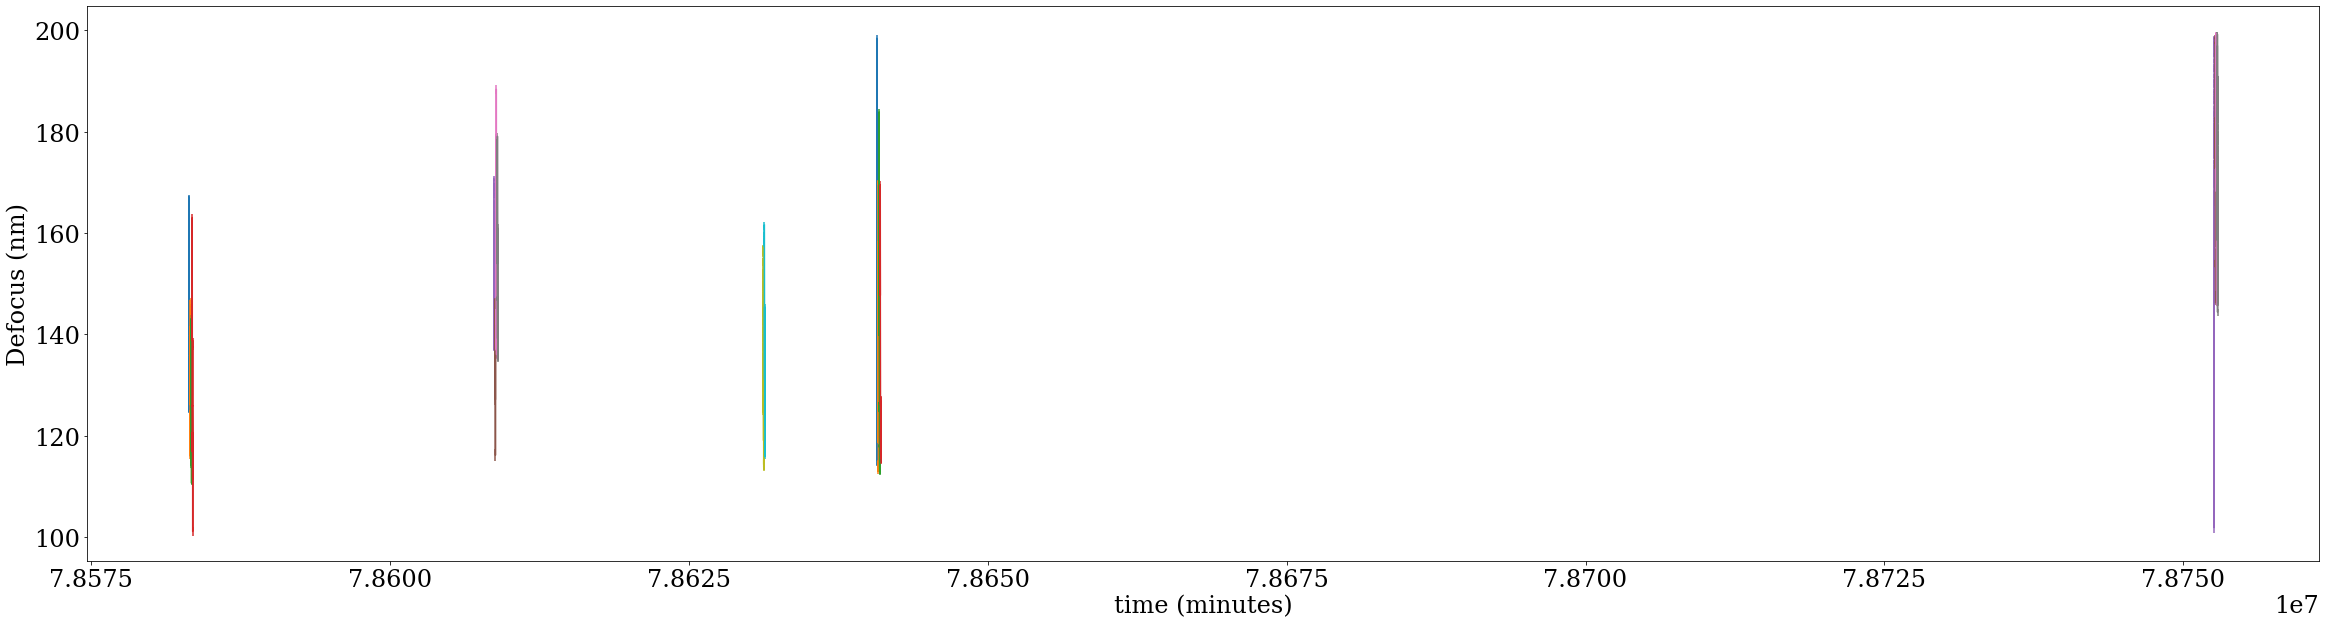

In [9]:
#plt.errorbar(mjds, defocuses, np.squeeze(np.abs(errs)))
plt.figure(figsize=(40,10))
nexps = 0
for i in range(len(defocuses)):
    if True:#(mjd_start[i]*60*24 > 7.860e7) and (mjd_start[i]*60*24 < 7.862e7):
        #plt.scatter(mjds[i]+mjd_start[i]*60*24,defocuses[i])
        plt.errorbar(np.asarray(mjds[i])+mjd_start[i]*60*24, np.asarray(defocuses[i]), np.abs(np.asarray(errs[i]).flatten()))
        plt.xlabel("time (minutes)")
        plt.ylabel("Defocus (nm)")
        nexps += len(defocuses[i])
plt.show()

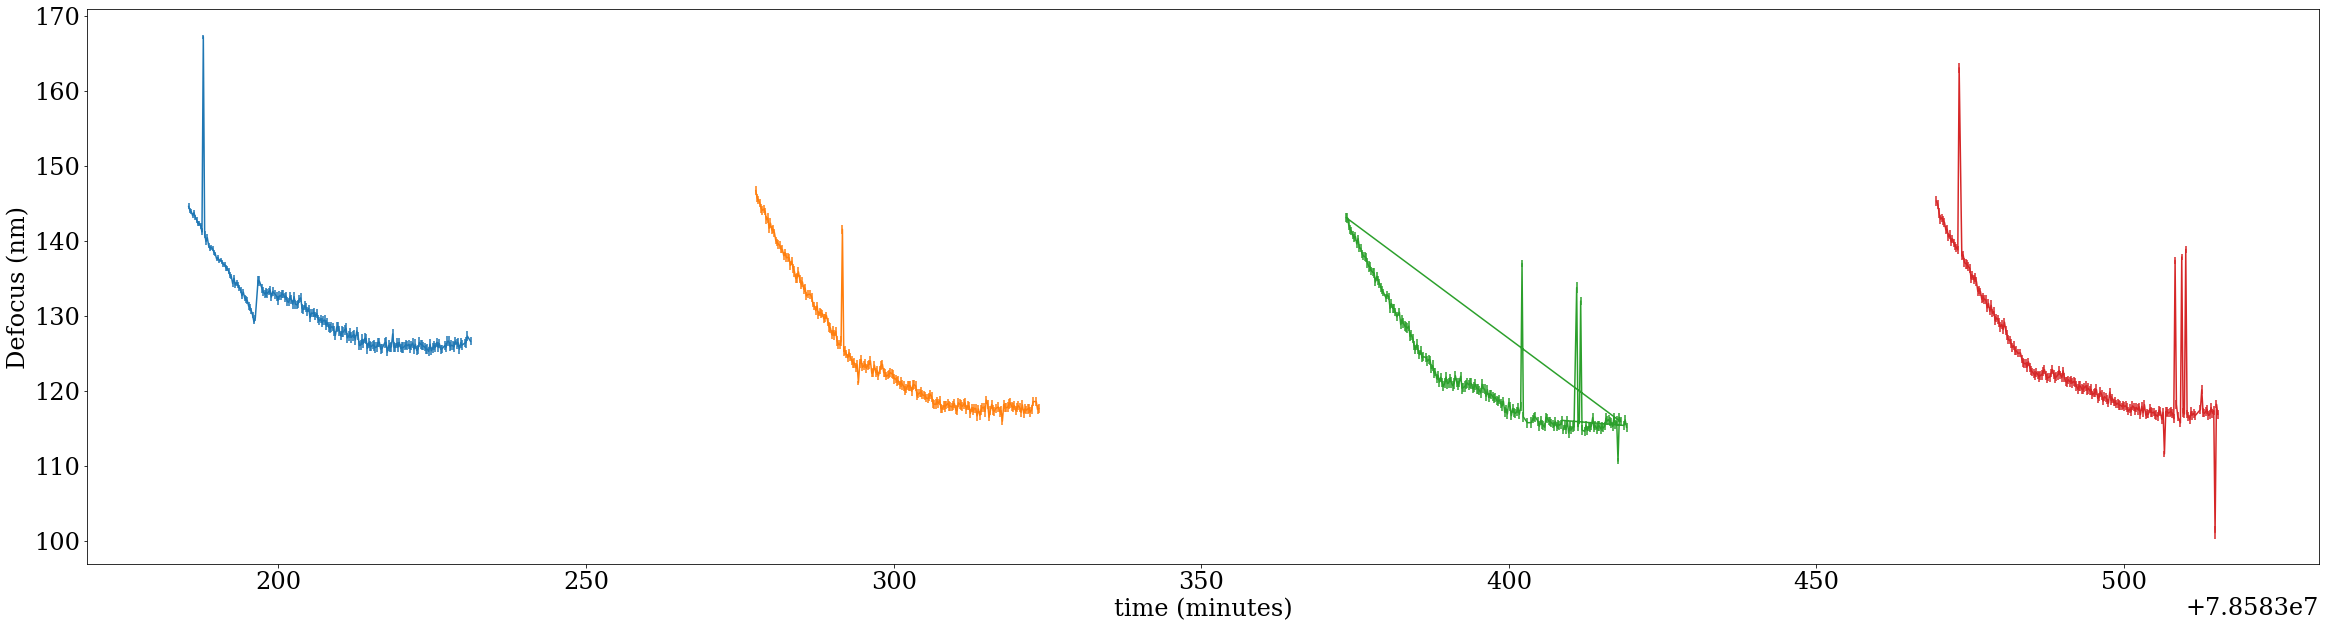

In [10]:
#plt.errorbar(mjds, defocuses, np.squeeze(np.abs(errs)))
plt.figure(figsize=(40,10))
nexps = 0
for i in range(len(defocuses)):
    if (mjd_start[i]*60*24 < 7.860e7):
    #if (mjd_start[i]*60*24 > 7.860e7) and (mjd_start[i]*60*24 < 7.862e7):
        #plt.scatter(mjds[i]+mjd_start[i]*60*24,defocuses[i])
        plt.errorbar(np.asarray(mjds[i])+mjd_start[i]*60*24, np.asarray(defocuses[i]), np.abs(np.asarray(errs[i]).flatten()))
        plt.xlabel("time (minutes)")
        plt.ylabel("Defocus (nm)")
        nexps += len(defocuses[i])
plt.show()

In [11]:
errs

[[np.float32(0.4091755),
  np.float32(0.3581769),
  np.float32(0.3451953),
  np.float32(0.33885098),
  np.float32(0.3598687),
  np.float32(0.34017748),
  np.float32(0.36310995),
  np.float32(0.35655394),
  np.float32(0.36856818),
  np.float32(0.36555138),
  np.float32(0.46046567),
  np.float32(0.28677404),
  np.float32(0.50365627),
  np.float32(0.4313806),
  np.float32(0.48718253),
  np.float32(0.383924),
  np.float32(0.35866398),
  np.float32(0.33604375),
  np.float32(0.33885747),
  np.float32(0.3343863),
  np.float32(0.30552155),
  np.float32(0.30807525),
  np.float32(0.3047041),
  np.float32(0.30941936),
  np.float32(0.28160205),
  np.float32(0.2897646),
  np.float32(0.30666035),
  np.float32(0.3165326),
  np.float32(0.34959322),
  np.float32(0.34112996),
  np.float32(0.3590543),
  np.float32(0.4157796),
  np.float32(0.3780398),
  np.float32(0.4115302),
  np.float32(0.4079275),
  np.float32(0.39918536),
  np.float32(0.425992),
  np.float32(0.4179508),
  np.float32(0.40140867),
  np.

In [12]:
all_mjds = np.concat([mjds[i] + mjd_start[i]*60*24 for i in range(len(mjds))])
all_defocuses = np.concat(defocuses)
all_errs = np.concat(errs)
all_fluxes = np.concat(fluxes)

all_aberrations = np.concat(aberrations)
all_pams = np.concat(pams)


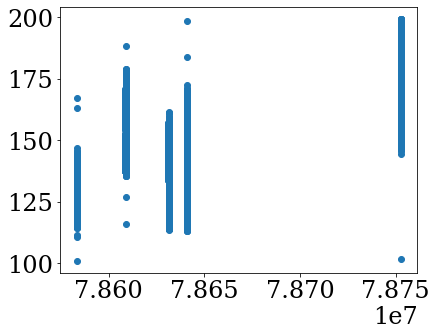

In [13]:
plt.scatter(all_mjds, all_defocuses)

In [14]:
kmeans = KMeans(n_clusters=5, random_state=0)
#kmeans = DBSCAN(eps=0.001, min_samples=10)
clumps = kmeans.fit_predict(np.reshape(all_mjds, (-1, 1)))

/Users/haydengreer/UQ/Subjects/Semester 2 2024/PHYS3900/hubble/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/haydengreer/UQ/Subjects/Semester 2 2024/PHYS3900/hubble/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/haydengreer/UQ/Subjects/Semester 2 2024/PHYS3900/hubble/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_dist_sq @ sample_weight


In [15]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(np.reshape(all_mjds, (-1, 1)))
idx = np.argsort(kmeans.cluster_centers_.sum(axis=1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(5)

clumps = lut[kmeans.labels_]


/Users/haydengreer/UQ/Subjects/Semester 2 2024/PHYS3900/hubble/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/haydengreer/UQ/Subjects/Semester 2 2024/PHYS3900/hubble/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/haydengreer/UQ/Subjects/Semester 2 2024/PHYS3900/hubble/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_dist_sq @ sample_weight


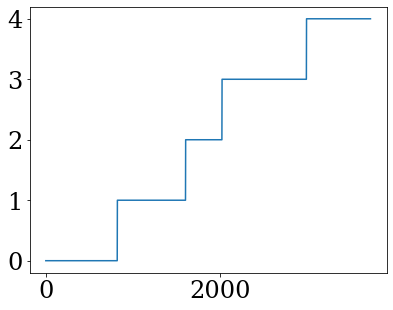

In [16]:
plt.plot(clumps)

3729


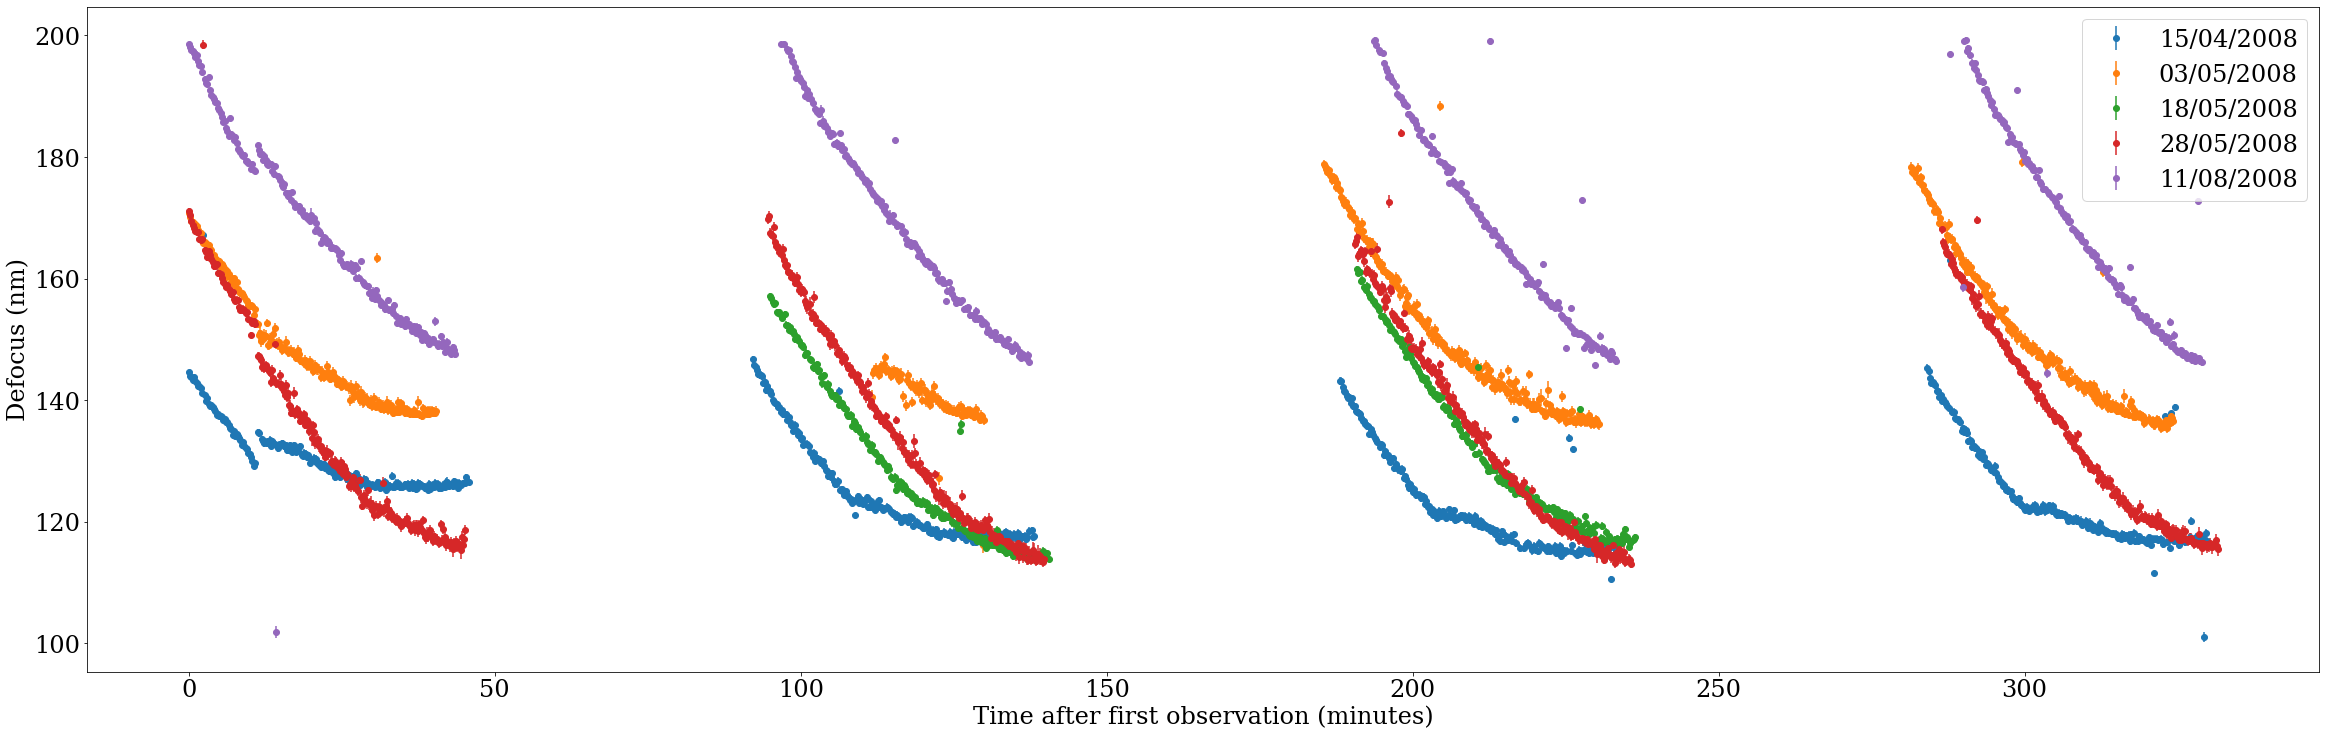

In [40]:
plt.figure(figsize=(40,12))
plt.xlabel("Time after first observation (minutes)")
plt.ylabel("Defocus (nm)")
num_points = 0
for i in range(5):#[0,2,3,4]:
    num_points += np.sum(clumps==i)
    off = 0 if i != 2 else 95
    plt.errorbar(all_mjds[clumps==i]-np.min(all_mjds[clumps==i]) + off, all_defocuses[clumps==i], yerr = np.abs(all_errs[clumps==i].flatten()), fmt = 'o')
#plt.legend(['Visit 1 (15/04/2008 F187N)', 'Visit 2 (03/05/2008 F166N)', 'Visit 3 (18/05/2008 F187N)', 'Visit 4 (28/05/2008 F166N)', 'Visit 5 (11/08/2008 F187N)'])
plt.legend(['15/04/2008', '03/05/2008', '18/05/2008', '28/05/2008', '11/08/2008'])

#plt.legend(['1','2', '3', '4', '5'])
print(num_points)

In [18]:
len(mjds[0])

205

3729


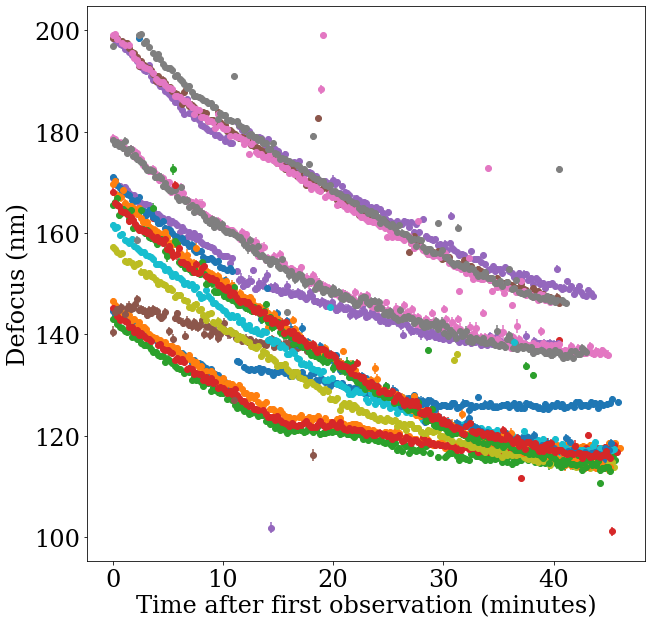

In [19]:
plt.figure(figsize=(10,10))
plt.xlabel("Time after first observation (minutes)")
plt.ylabel("Defocus (nm)")
num_points = 0
for i in range(18):#[0,2,3,4]:
    num_points += len(mjds[i])
    plt.errorbar(mjds[i]-np.min(mjds[i]), defocuses[i], yerr = np.abs(errs[i]), fmt = 'o')
#plt.legend(['Visit 1 (15/04/2008 F187N)', 'Visit 2 (03/05/2008 F166N)', 'Visit 3 (18/05/2008 F187N)', 'Visit 4 (28/05/2008 F166N)', 'Visit 5 (11/08/2008 F187N)'])
#plt.legend(['1','2', '3', '4', '5'])
#plt.legend([str(i) for i in range(18)])
print(num_points)

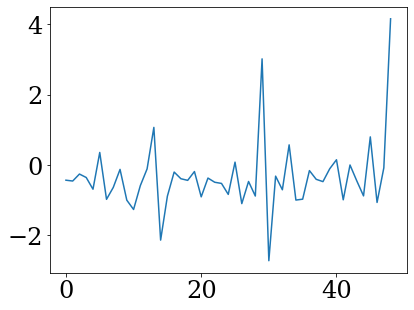

In [20]:
plt.plot(np.diff(all_defocuses[clumps==4][:50]))

3729


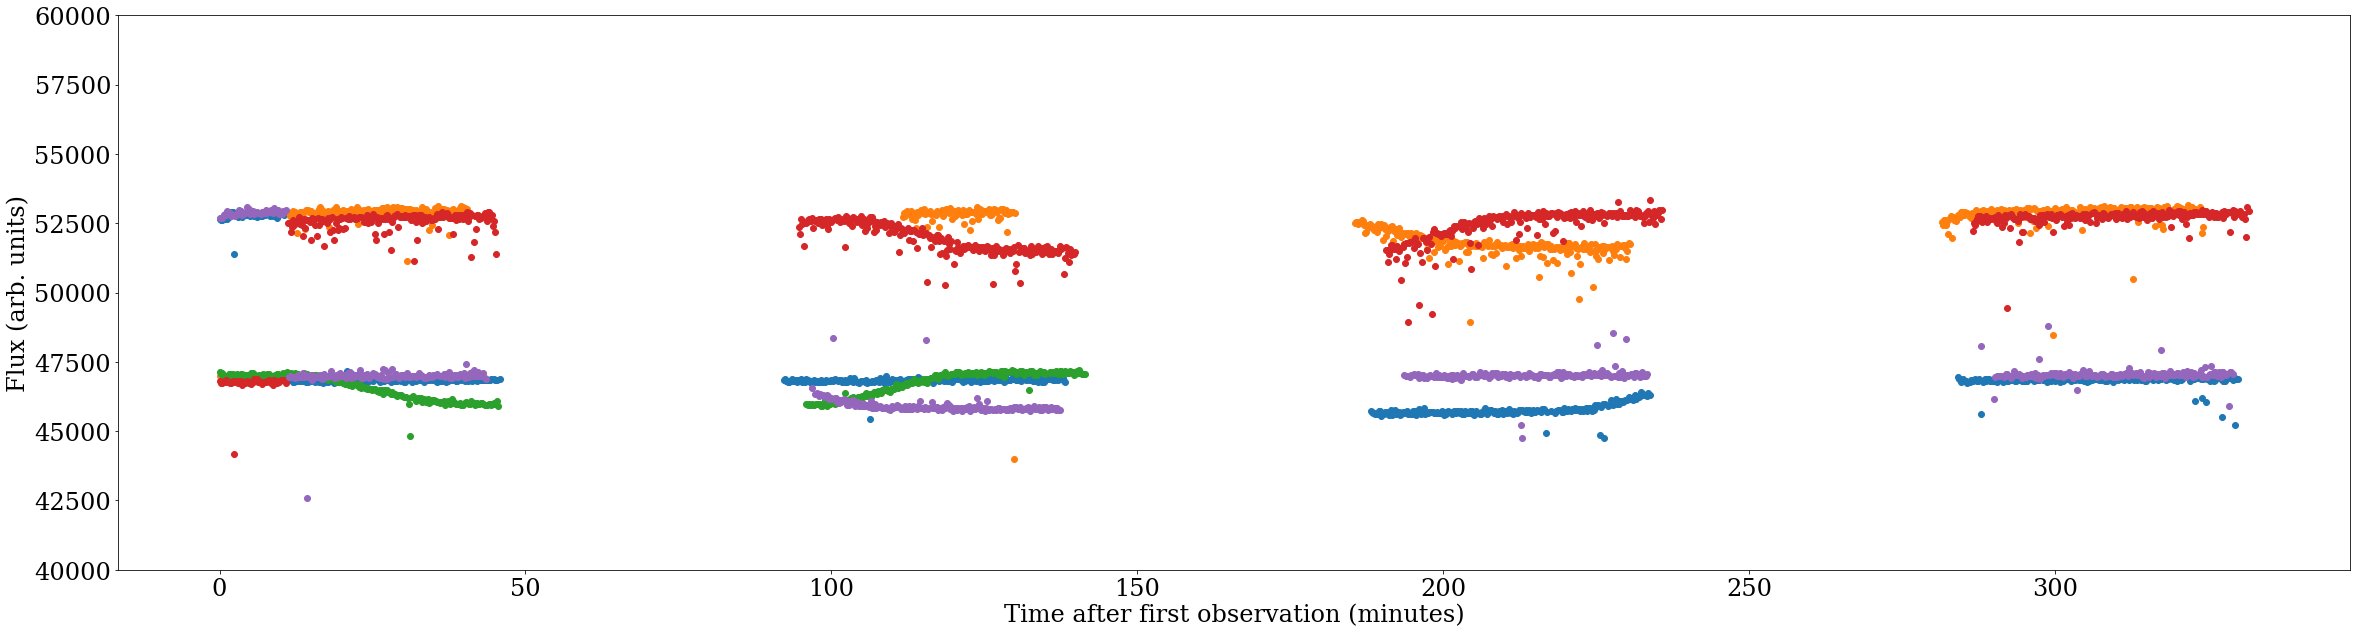

In [21]:
plt.figure(figsize=(40,10))
plt.xlabel("Time after first observation (minutes)")
plt.ylabel("Flux (arb. units)")
plt.ylim((40000, 60000))
#plt.ylabel("Defocus (nm)")
num_points = 0
for i in range(5):#[0,2,3,4]:
    num_points += np.sum(clumps==i)
    plt.scatter(all_mjds[clumps==i]-np.min(all_mjds[clumps==i]), 10**all_fluxes[clumps==i])
print(num_points)

736


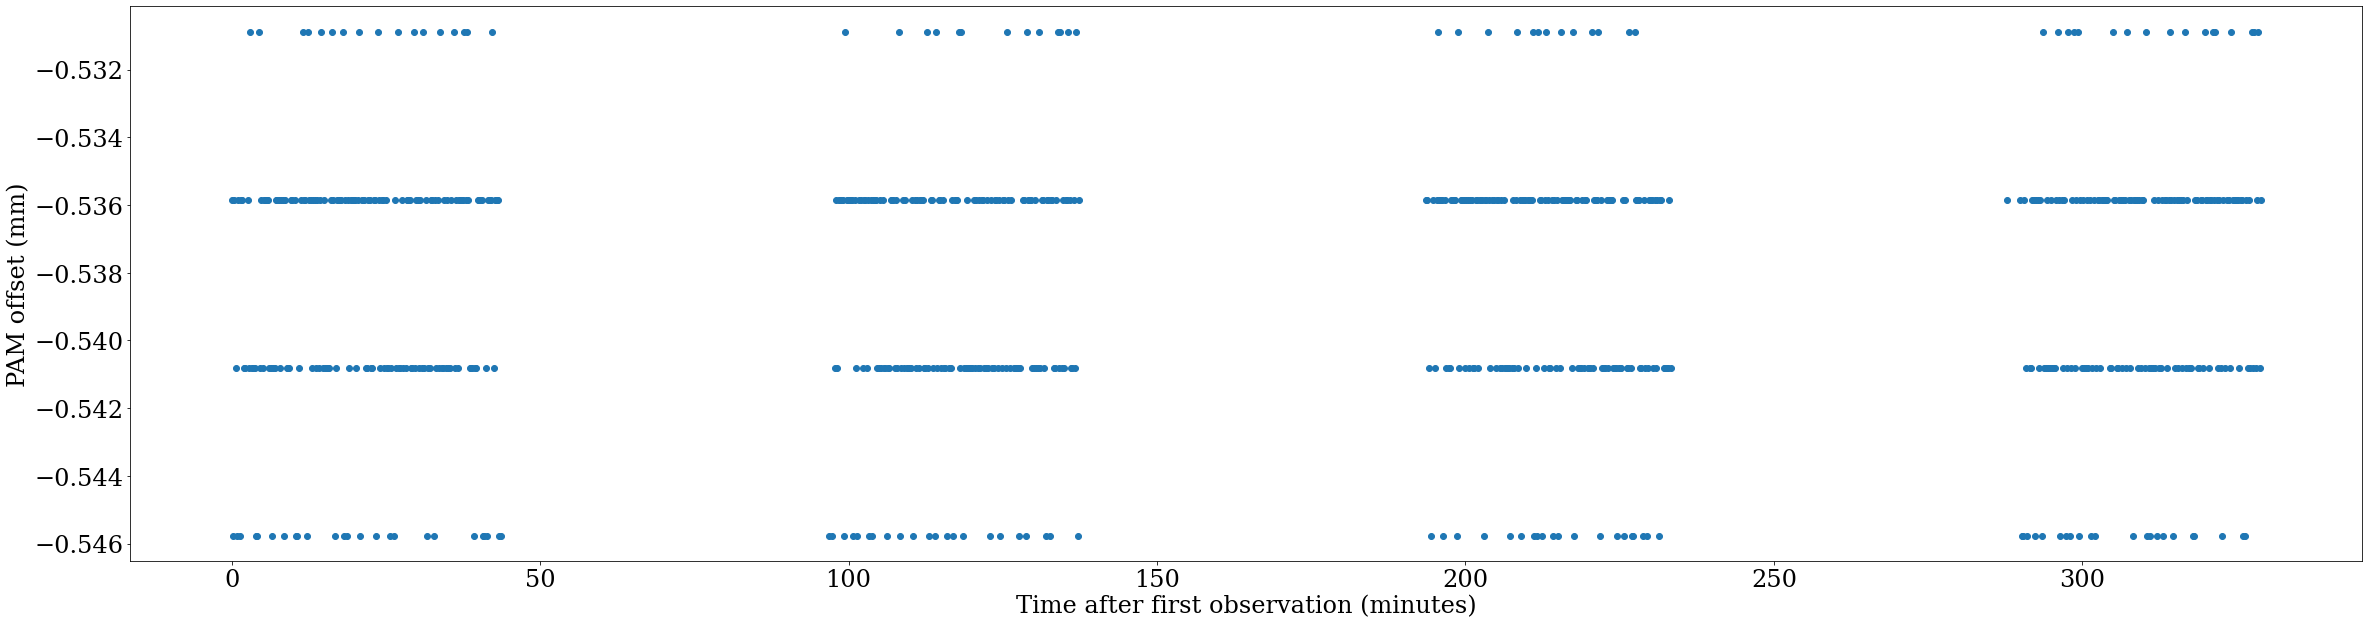

In [22]:
plt.figure(figsize=(40,10))
plt.xlabel("Time after first observation (minutes)")
plt.ylabel("PAM offset (mm)")
#plt.ylim((40000, 60000))
#plt.ylabel("Defocus (nm)")
num_points = 0
for i in [4]:#[0,2,3,4]:
    num_points += np.sum(clumps==i)
    plt.scatter(all_mjds[clumps==i]-np.min(all_mjds[clumps==i]), all_pams[clumps==i])
print(num_points)

In [23]:
mjds_files = np.load("../batch/mjds.npy")

In [24]:
kmeans = KMeans(n_clusters=20, random_state=1).fit(np.reshape(mjds_files, (-1, 1)))
idx = np.argsort(kmeans.cluster_centers_.sum(axis=1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(20)

mjd_clumps = lut[kmeans.labels_]


/Users/haydengreer/UQ/Subjects/Semester 2 2024/PHYS3900/hubble/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/haydengreer/UQ/Subjects/Semester 2 2024/PHYS3900/hubble/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/haydengreer/UQ/Subjects/Semester 2 2024/PHYS3900/hubble/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_dist_sq @ sample_weight


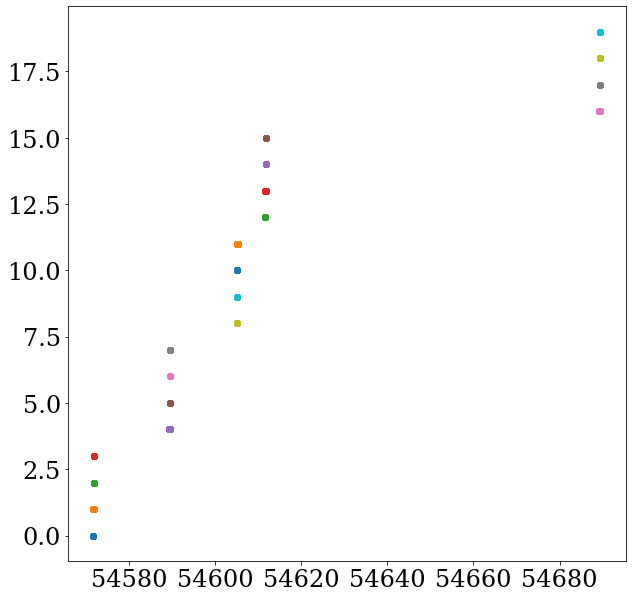

In [25]:
plt.figure(figsize=(10,10))
for i in range(20):
#for i in [3,9,12,19]:
#for i in [0,6,16,17]:

    plt.scatter(mjds_files[mjd_clumps == i], mjd_clumps[mjd_clumps==i])

In [26]:
pca = PCA(n_components=5)
pca.fit(np.concat([aberrations[i] for i in range(18) if i not in [0, 4, 10, 14]]))
print(pca.singular_values_)
print(pca.components_)
print(pca.explained_variance_ratio_)
components = pca.components_

[1137.9839   536.64966  245.93068  181.42348  128.73154]
[[ 0.96577674  0.09509908  0.14358602  0.00898936 -0.10714063 -0.00970114
   0.05850607  0.08762516 -0.03361966 -0.04946268 -0.00266493  0.10618541]
 [-0.10819881 -0.02645235  0.85811454  0.10852322  0.27571484  0.30315077
   0.00491339 -0.1232524  -0.10350533 -0.15234146  0.05109423  0.14067402]
 [ 0.16989857  0.24623016 -0.19821472  0.19505228  0.76333004  0.07616936
  -0.2332945  -0.21542443  0.13914423  0.1777222  -0.01652019 -0.3043731 ]
 [-0.06371627  0.19138245 -0.07739151 -0.35582328  0.35468677  0.07403611
  -0.06716244  0.7371139  -0.12147516 -0.30616328 -0.12642291  0.15200888]
 [-0.10300388  0.7549591  -0.14835939  0.07395969 -0.1084423   0.21055867
   0.29673353 -0.24866612 -0.23188943  0.02017173 -0.1290255   0.33932117]]
[0.75591505 0.16810572 0.03530419 0.01921267 0.00967321]


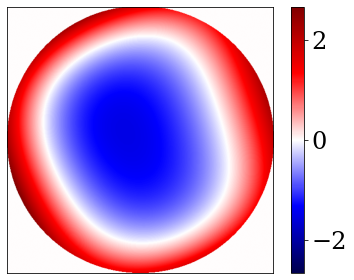

In [27]:
ap = dl.AberratedAperture(dl.CircularAperture(radius=1.2), noll_inds=np.arange(4,4+12), coefficients=components[0])
coords = dlu.pixel_coords(512, 2.4)

opd = ap.eval_basis(coords)#*1e9
m = np.max(np.abs(opd))
plt.imshow(opd, cmap='seismic', vmin=-m, vmax=m)
plt.xticks([])
plt.yticks([])
plt.colorbar()


In [28]:
print([len(x) for x in aberrations])

[205, 210, 200, 206, 210, 96, 244, 234, 210, 208, 234, 245, 245, 246, 196, 182, 179, 179]


[127.26761   45.3987    27.32107   18.074528  11.879877]
[[ 0.93643725  0.15743838 -0.26526037  0.01589176  0.15896475 -0.01062312
   0.01432398  0.01387731 -0.01420804 -0.00278179 -0.03629444 -0.01937969]
 [ 0.2990279  -0.03082444  0.9064105   0.10024741 -0.21109569 -0.00446046
  -0.00360536  0.12399692  0.09103716  0.06566867  0.06027057  0.04243076]
 [-0.05283612 -0.07176767 -0.04540778 -0.18110648  0.20431729  0.03801968
   0.07296842  0.8155833   0.010707    0.43549508 -0.23171678 -0.00643995]
 [-0.16521129  0.8425614   0.12750345  0.23664531  0.340161    0.07161798
   0.13976808 -0.03454966 -0.01057382  0.16586705  0.11462894 -0.09058914]
 [ 0.03653385  0.04134567 -0.13462475  0.13998362 -0.52282083  0.10101522
   0.13996837 -0.301469   -0.06134668  0.7135997  -0.22641855 -0.03102984]]
[77.49782     9.861445    3.5714874   1.5631031   0.67527026]
[119.57369   43.84843   29.192146  17.539387  10.598669]
[[ 0.93889076  0.16962382 -0.22482547  0.0018189   0.18094474 -0.00354027
   0

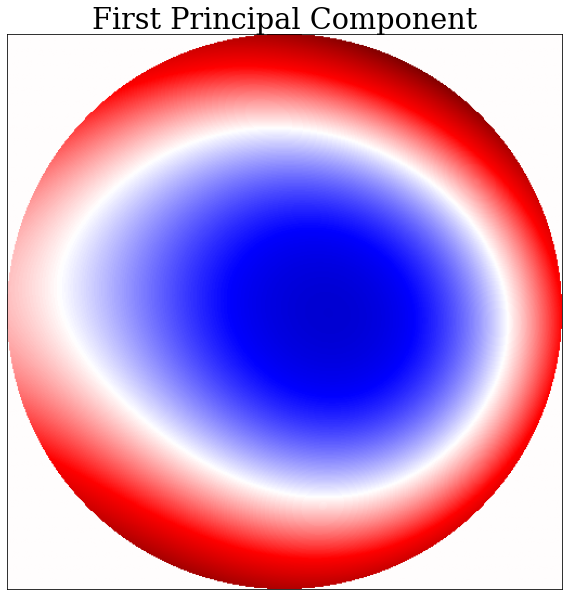

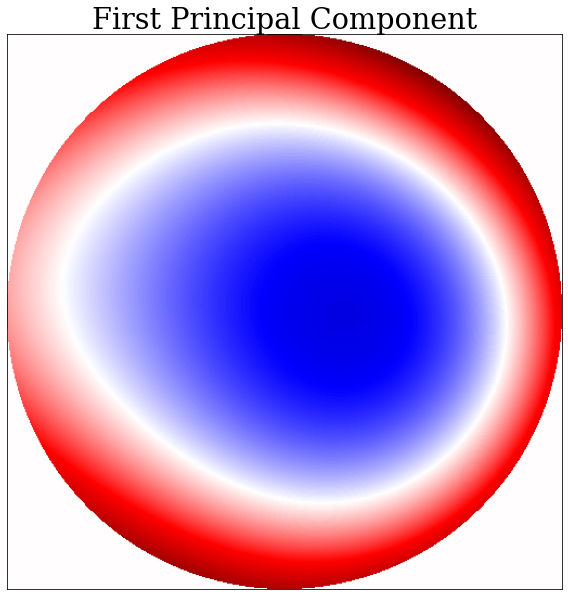

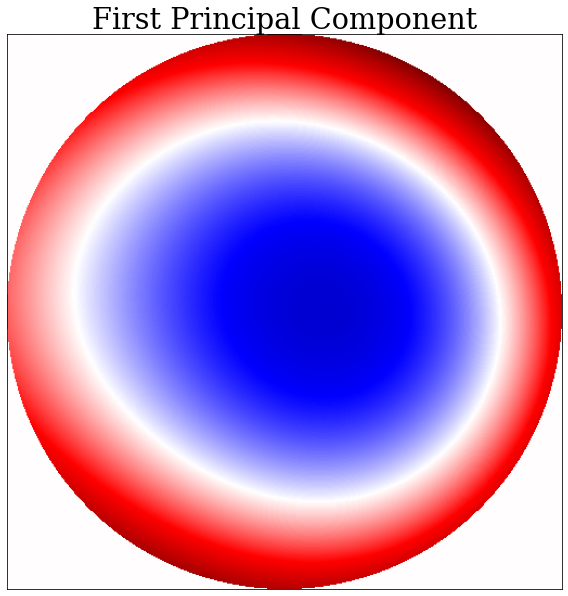

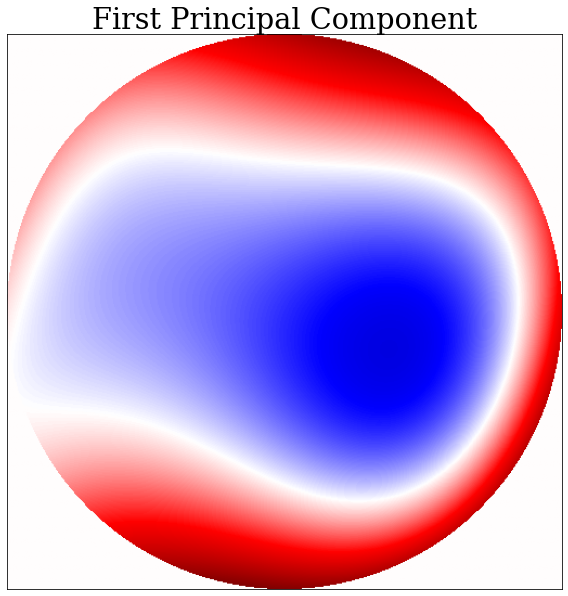

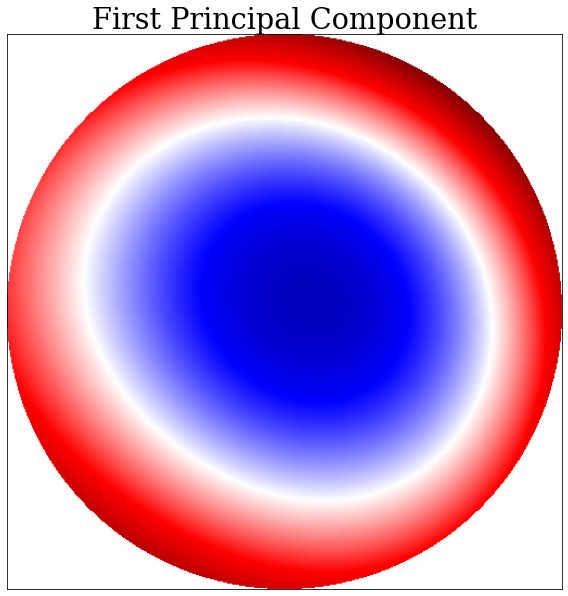

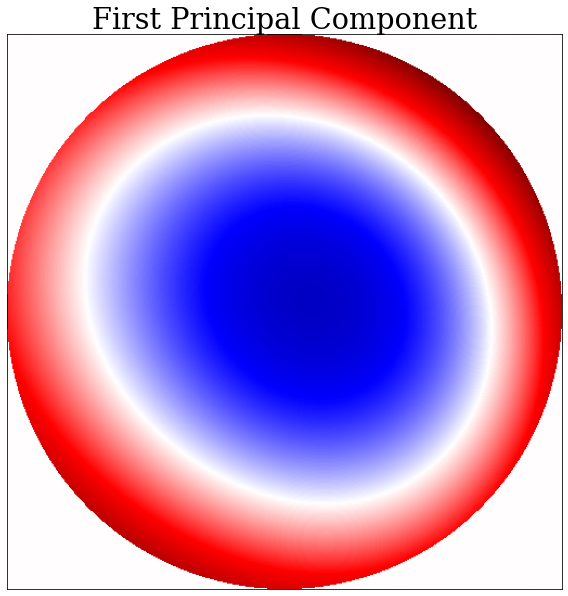

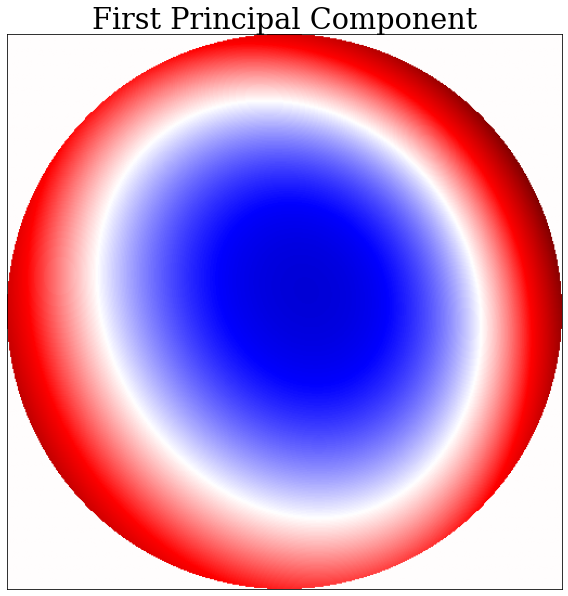

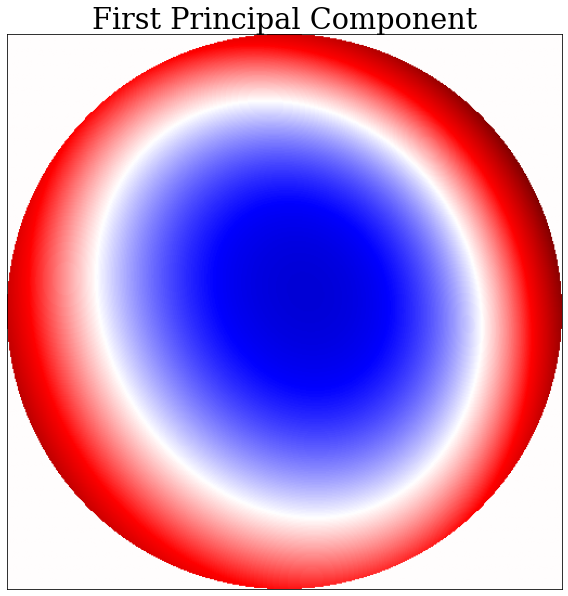

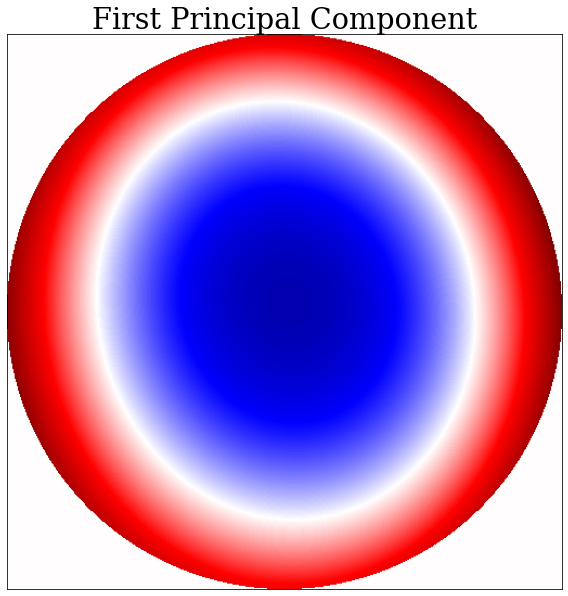

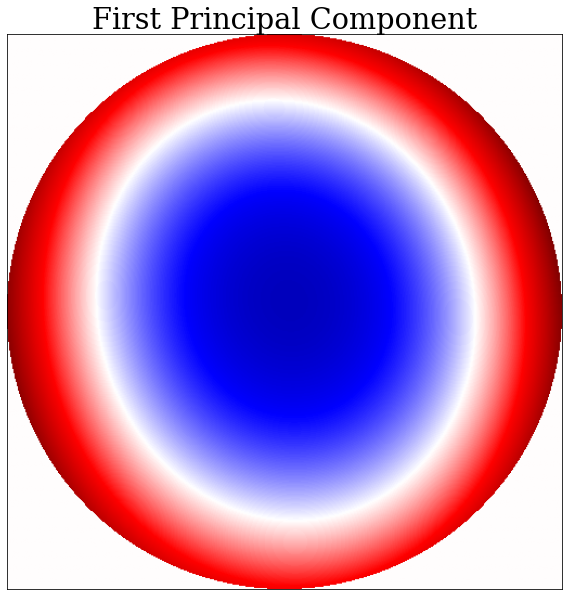

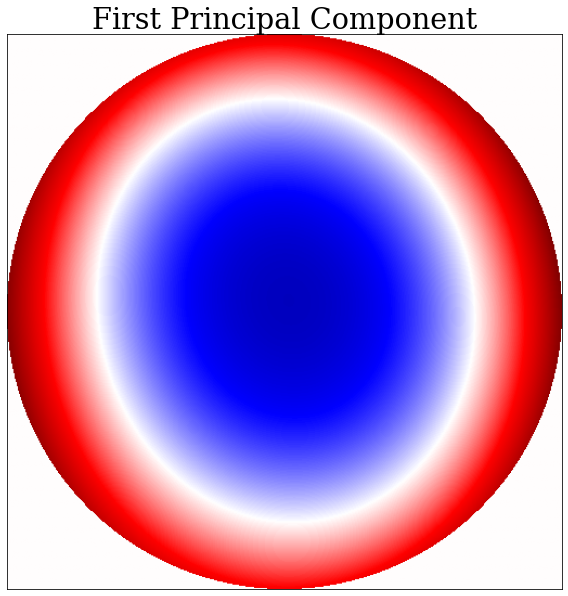

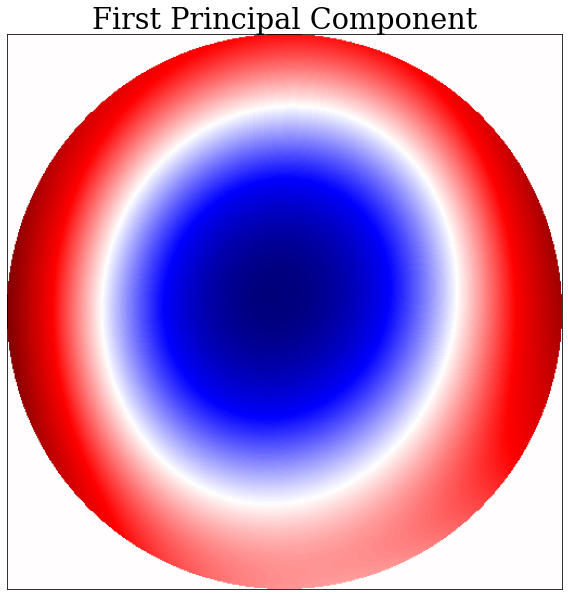

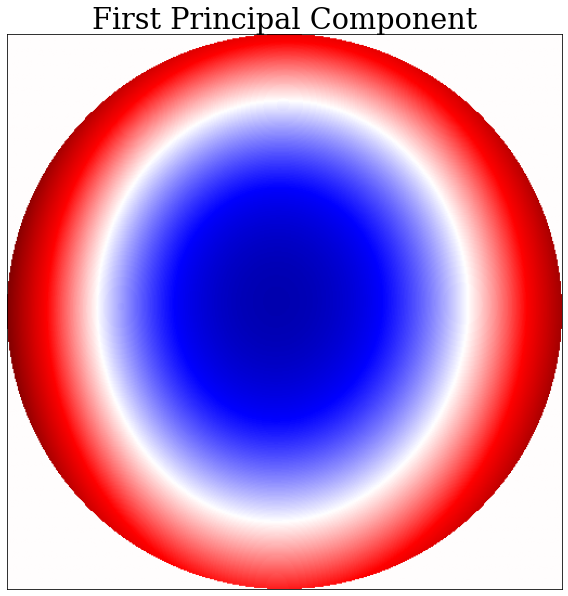

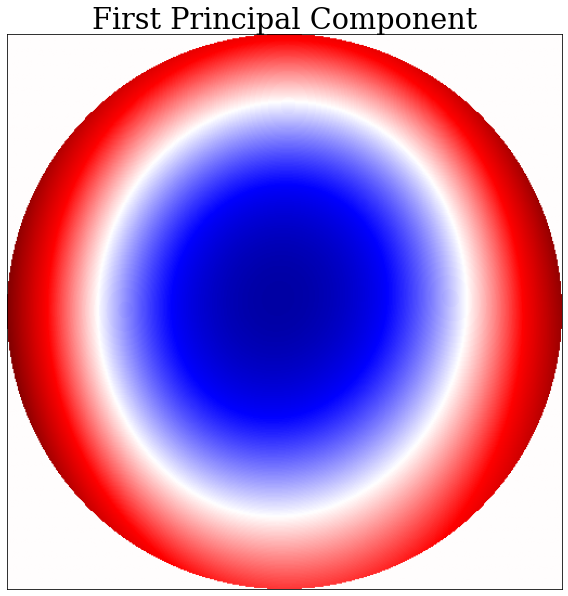

In [42]:
angles = [
    82.985588,82.985588,82.985588,82.985588,
    71.344803,71.344803,71.344803,71.344803,
    60.98637, 60.98637,
    56.314529,56.314529,56.314529,56.314529,
    329.616394,329.616394,329.616394,329.616394,
]

for i in range(20):
    if i in [0, 4, 10, 14]:# or i%4 == 0:
        continue
    try:
        pca = PCA(n_components=5)
        pca.fit(aberrations[i])
        print(pca.singular_values_)
        print(pca.components_)
        print(pca.explained_variance_)
        components = pca.components_
        ap = dl.AberratedAperture(dl.CircularAperture(radius=1.2), noll_inds=np.arange(4,4+12), coefficients=components[0])
        coords = dlu.pixel_coords(512, 2.4)

        opd = ap.eval_basis(coords)#*1e9
        m = np.max(np.abs(opd))
        plt.figure(figsize=(10,10))
        plt.imshow(opd, cmap='seismic', vmin=-m, vmax=m)
        plt.xticks([])
        plt.yticks([])
        #plt.colorbar()
        #plt.gca().axline((256,256), (257, 256 + np.tan(dlu.deg2rad(-angles[i]))))
        #plt.title(f"{i}")
        plt.title("First Principal Component")
        #plt.gca().axline((256,256), (257, 256 + np.tan(dlu.deg2rad(-angles[i]+90))))
        
    except Exception as e:
        print(e)

In [30]:
162/5

32.4

In [31]:
# smoothing for orbits
kmeans = KMeans(n_clusters=18, random_state=0).fit(np.reshape(all_mjds, (-1, 1)))
idx = np.argsort(kmeans.cluster_centers_.sum(axis=1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(18)

clumps_i = lut[kmeans.labels_]



/Users/haydengreer/UQ/Subjects/Semester 2 2024/PHYS3900/hubble/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/haydengreer/UQ/Subjects/Semester 2 2024/PHYS3900/hubble/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/haydengreer/UQ/Subjects/Semester 2 2024/PHYS3900/hubble/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_dist_sq @ sample_weight


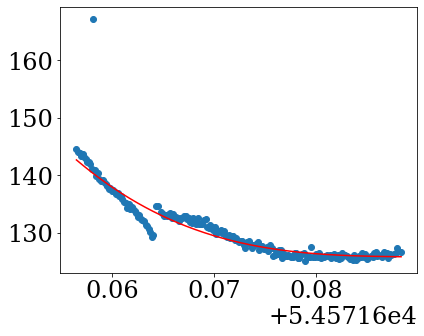

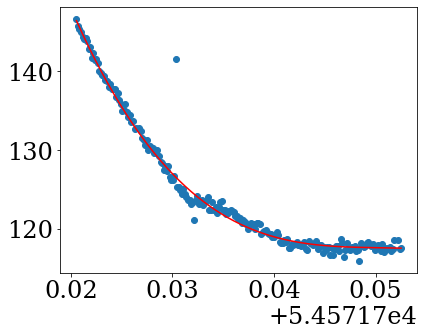

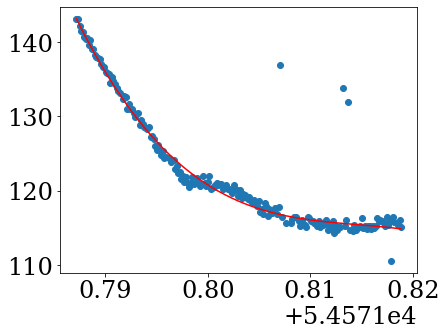

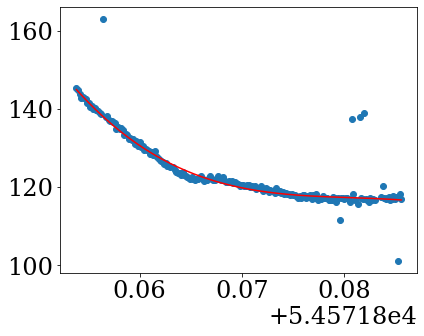

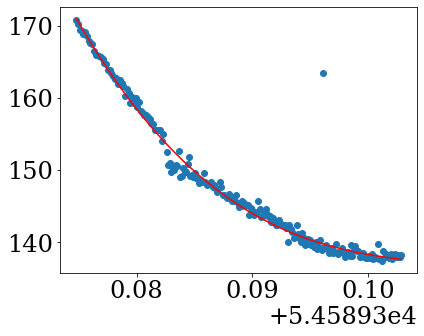

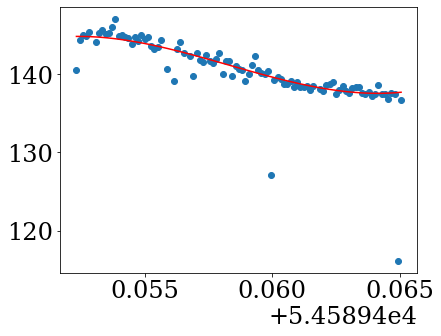

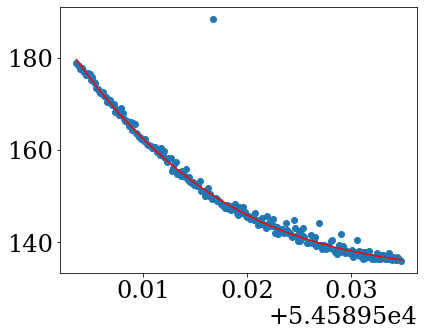

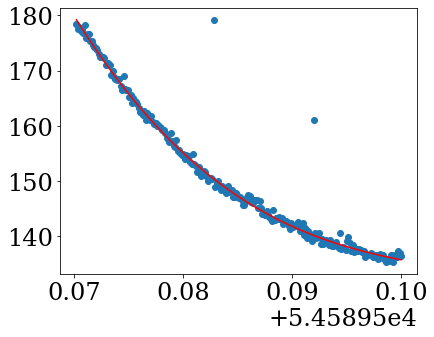

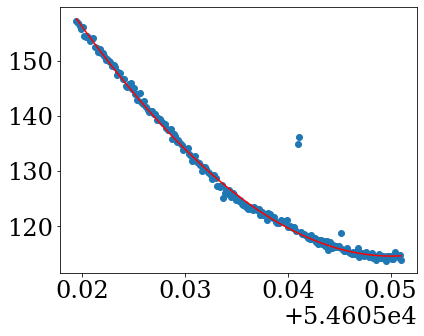

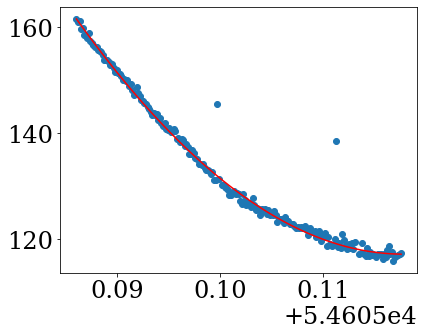

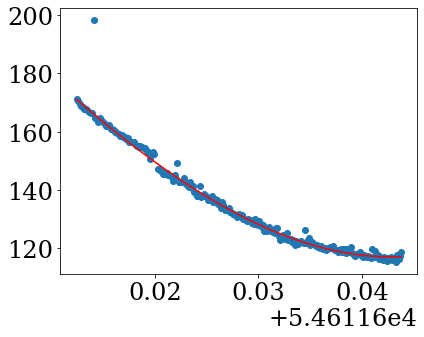

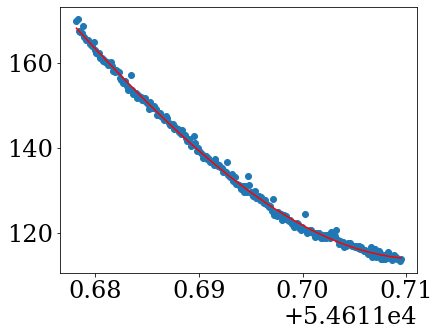

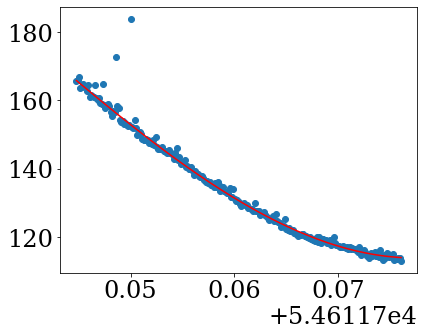

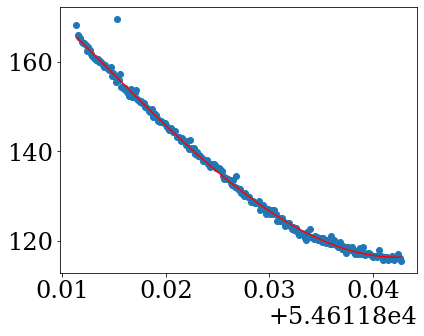

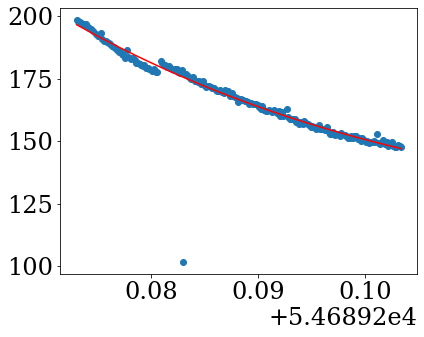

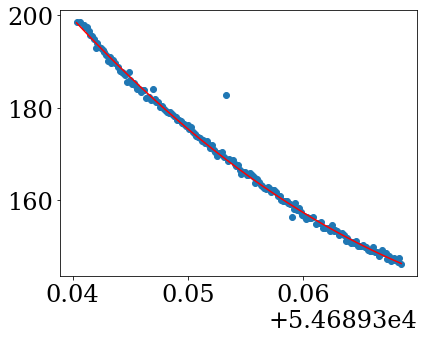

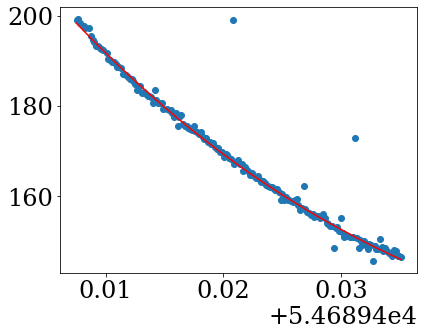

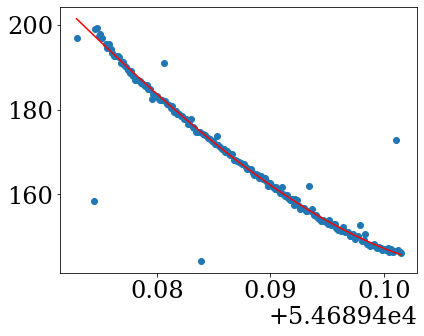

In [32]:
splines = []
for i in range(18):
    plt.figure()
    order = np.argsort(all_mjds[clumps_i==i])
    x = all_mjds[clumps_i==i][order]/24/60#-np.min(all_mjds[clumps_i==i][order])
    y = all_defocuses[clumps_i==i][order]
    plt.scatter(x, y)
    interp = scipy.interpolate.BSpline(*scipy.interpolate.splrep(x, y ,s=1e7))#5500))

    good = np.abs(y - interp(x)) < 10
    x2 = all_mjds[clumps_i==i][order][good]/24/60#-np.min(all_mjds[clumps_i==i][order][good])
    y2 = all_defocuses[clumps_i==i][order][good]
    interp2 = scipy.interpolate.BSpline(*scipy.interpolate.splrep(x2, y2 ,s=1e7))#5500))
    splines.append(interp2)
    plt.plot(x,interp2(x), color='red')

splines.insert(8, None)
splines.insert(11, None)

#np.save("splines.npy", splines, allow_pickle=True)


In [33]:
splines[8]